# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:46 - loss: 0.6937

  25/1875 [..............................] - ETA: 3s - loss: 0.5627   

  50/1875 [..............................] - ETA: 3s - loss: 0.4812

  77/1875 [>.............................] - ETA: 3s - loss: 0.4346

 106/1875 [>.............................] - ETA: 3s - loss: 0.4038

 133/1875 [=>............................] - ETA: 3s - loss: 0.3836

 156/1875 [=>............................] - ETA: 3s - loss: 0.3701

 189/1875 [==>...........................] - ETA: 3s - loss: 0.3545

 223/1875 [==>...........................] - ETA: 3s - loss: 0.3414

 256/1875 [===>..........................] - ETA: 2s - loss: 0.3307

 290/1875 [===>..........................] - ETA: 2s - loss: 0.3212

 323/1875 [====>.........................] - ETA: 2s - loss: 0.3132

 356/1875 [====>.........................] - ETA: 2s - loss: 0.3061

 387/1875 [=====>........................] - ETA: 2s - loss: 0.3001

 414/1875 [=====>........................] - ETA: 2s - loss: 0.2952

 449/1875 [======>.......................] - ETA: 2s - loss: 0.2895

 482/1875 [======>.......................] - ETA: 2s - loss: 0.2846

 510/1875 [=======>......................] - ETA: 2s - loss: 0.2807

 540/1875 [=======>......................] - ETA: 2s - loss: 0.2768

 572/1875 [========>.....................] - ETA: 2s - loss: 0.2729

 605/1875 [========>.....................] - ETA: 2s - loss: 0.2691

 637/1875 [=========>....................] - ETA: 2s - loss: 0.2657

 665/1875 [=========>....................] - ETA: 2s - loss: 0.2629

 694/1875 [==========>...................] - ETA: 1s - loss: 0.2601

 722/1875 [==========>...................] - ETA: 1s - loss: 0.2575

 751/1875 [===========>..................] - ETA: 1s - loss: 0.2550

 782/1875 [===========>..................] - ETA: 1s - loss: 0.2524

 815/1875 [============>.................] - ETA: 1s - loss: 0.2498

 845/1875 [============>.................] - ETA: 1s - loss: 0.2475

 874/1875 [============>.................] - ETA: 1s - loss: 0.2454

 903/1875 [=============>................] - ETA: 1s - loss: 0.2434

 932/1875 [=============>................] - ETA: 1s - loss: 0.2415

 966/1875 [==============>...............] - ETA: 1s - loss: 0.2393

 996/1875 [==============>...............] - ETA: 1s - loss: 0.2374

1026/1875 [===============>..............] - ETA: 1s - loss: 0.2356

1053/1875 [===============>..............] - ETA: 1s - loss: 0.2340

1085/1875 [================>.............] - ETA: 1s - loss: 0.2322

1113/1875 [================>.............] - ETA: 1s - loss: 0.2307

1141/1875 [=================>............] - ETA: 1s - loss: 0.2293

1169/1875 [=================>............] - ETA: 1s - loss: 0.2278

1197/1875 [==================>...........] - ETA: 1s - loss: 0.2264

1230/1875 [==================>...........] - ETA: 1s - loss: 0.2249

1264/1875 [===================>..........] - ETA: 1s - loss: 0.2233

1293/1875 [===================>..........] - ETA: 0s - loss: 0.2220

1322/1875 [====================>.........] - ETA: 0s - loss: 0.2207

1357/1875 [====================>.........] - ETA: 0s - loss: 0.2192

1384/1875 [=====================>........] - ETA: 0s - loss: 0.2181

1412/1875 [=====================>........] - ETA: 0s - loss: 0.2170

1442/1875 [======================>.......] - ETA: 0s - loss: 0.2158

1469/1875 [======================>.......] - ETA: 0s - loss: 0.2148

1499/1875 [======================>.......] - ETA: 0s - loss: 0.2137

1527/1875 [=======================>......] - ETA: 0s - loss: 0.2126

1552/1875 [=======================>......] - ETA: 0s - loss: 0.2117

1584/1875 [========================>.....] - ETA: 0s - loss: 0.2106

1614/1875 [========================>.....] - ETA: 0s - loss: 0.2096

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2085

1679/1875 [=========================>....] - ETA: 0s - loss: 0.2075

1707/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1736/1875 [==========================>...] - ETA: 0s - loss: 0.2057

1767/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1798/1875 [===========================>..] - ETA: 0s - loss: 0.2038

1830/1875 [============================>.] - ETA: 0s - loss: 0.2029

1861/1875 [============================>.] - ETA: 0s - loss: 0.2020

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2016


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1095

  37/1875 [..............................] - ETA: 2s - loss: 0.1081

  71/1875 [>.............................] - ETA: 2s - loss: 0.1085

 104/1875 [>.............................] - ETA: 2s - loss: 0.1087

 137/1875 [=>............................] - ETA: 2s - loss: 0.1087

 169/1875 [=>............................] - ETA: 2s - loss: 0.1087

 197/1875 [==>...........................] - ETA: 2s - loss: 0.1087

 232/1875 [==>...........................] - ETA: 2s - loss: 0.1087

 263/1875 [===>..........................] - ETA: 2s - loss: 0.1086

 294/1875 [===>..........................] - ETA: 2s - loss: 0.1086

 327/1875 [====>.........................] - ETA: 2s - loss: 0.1086

 356/1875 [====>.........................] - ETA: 2s - loss: 0.1085

 386/1875 [=====>........................] - ETA: 2s - loss: 0.1085

 415/1875 [=====>........................] - ETA: 2s - loss: 0.1084

 444/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 477/1875 [======>.......................] - ETA: 2s - loss: 0.1083

 507/1875 [=======>......................] - ETA: 2s - loss: 0.1082

 535/1875 [=======>......................] - ETA: 2s - loss: 0.1082

 565/1875 [========>.....................] - ETA: 2s - loss: 0.1081

 593/1875 [========>.....................] - ETA: 2s - loss: 0.1081

 620/1875 [========>.....................] - ETA: 2s - loss: 0.1080

 647/1875 [=========>....................] - ETA: 2s - loss: 0.1080

 676/1875 [=========>....................] - ETA: 1s - loss: 0.1079

 710/1875 [==========>...................] - ETA: 1s - loss: 0.1079

 740/1875 [==========>...................] - ETA: 1s - loss: 0.1078

 769/1875 [===========>..................] - ETA: 1s - loss: 0.1078

 798/1875 [===========>..................] - ETA: 1s - loss: 0.1077

 829/1875 [============>.................] - ETA: 1s - loss: 0.1077

 859/1875 [============>.................] - ETA: 1s - loss: 0.1076

 890/1875 [=============>................] - ETA: 1s - loss: 0.1076

 925/1875 [=============>................] - ETA: 1s - loss: 0.1075

 958/1875 [==============>...............] - ETA: 1s - loss: 0.1074

 986/1875 [==============>...............] - ETA: 1s - loss: 0.1074

1013/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1042/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1069/1875 [================>.............] - ETA: 1s - loss: 0.1072

1097/1875 [================>.............] - ETA: 1s - loss: 0.1072

1124/1875 [================>.............] - ETA: 1s - loss: 0.1071

1154/1875 [=================>............] - ETA: 1s - loss: 0.1071

1185/1875 [=================>............] - ETA: 1s - loss: 0.1070

1221/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1257/1875 [===================>..........] - ETA: 1s - loss: 0.1069

1282/1875 [===================>..........] - ETA: 0s - loss: 0.1068

1310/1875 [===================>..........] - ETA: 0s - loss: 0.1068

1345/1875 [====================>.........] - ETA: 0s - loss: 0.1067

1372/1875 [====================>.........] - ETA: 0s - loss: 0.1066

1394/1875 [=====================>........] - ETA: 0s - loss: 0.1066

1422/1875 [=====================>........] - ETA: 0s - loss: 0.1066

1449/1875 [======================>.......] - ETA: 0s - loss: 0.1065

1475/1875 [======================>.......] - ETA: 0s - loss: 0.1065

1503/1875 [=======================>......] - ETA: 0s - loss: 0.1064

1529/1875 [=======================>......] - ETA: 0s - loss: 0.1064

1557/1875 [=======================>......] - ETA: 0s - loss: 0.1063

1583/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1604/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1627/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1650/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1679/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1706/1875 [==========================>...] - ETA: 0s - loss: 0.1061

1736/1875 [==========================>...] - ETA: 0s - loss: 0.1060

1763/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1792/1875 [===========================>..] - ETA: 0s - loss: 0.1060

1821/1875 [============================>.] - ETA: 0s - loss: 0.1059

1851/1875 [============================>.] - ETA: 0s - loss: 0.1059

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1058


Epoch 3/5


   1/1875 [..............................] - ETA: 5s - loss: 0.1035

  29/1875 [..............................] - ETA: 3s - loss: 0.1003

  54/1875 [..............................] - ETA: 3s - loss: 0.0999

  81/1875 [>.............................] - ETA: 3s - loss: 0.0996

 108/1875 [>.............................] - ETA: 3s - loss: 0.0994

 134/1875 [=>............................] - ETA: 3s - loss: 0.0993

 159/1875 [=>............................] - ETA: 3s - loss: 0.0992

 187/1875 [=>............................] - ETA: 3s - loss: 0.0991

 219/1875 [==>...........................] - ETA: 3s - loss: 0.0990

 248/1875 [==>...........................] - ETA: 3s - loss: 0.0990

 281/1875 [===>..........................] - ETA: 2s - loss: 0.0990

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0990

 347/1875 [====>.........................] - ETA: 2s - loss: 0.0990

 378/1875 [=====>........................] - ETA: 2s - loss: 0.0990

 412/1875 [=====>........................] - ETA: 2s - loss: 0.0989

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0989

 476/1875 [======>.......................] - ETA: 2s - loss: 0.0989

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0989

 538/1875 [=======>......................] - ETA: 2s - loss: 0.0988

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0988

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0988

 631/1875 [=========>....................] - ETA: 2s - loss: 0.0988

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0987

 694/1875 [==========>...................] - ETA: 1s - loss: 0.0987

 729/1875 [==========>...................] - ETA: 1s - loss: 0.0987

 757/1875 [===========>..................] - ETA: 1s - loss: 0.0987

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0987

 813/1875 [============>.................] - ETA: 1s - loss: 0.0987

 847/1875 [============>.................] - ETA: 1s - loss: 0.0986

 879/1875 [=============>................] - ETA: 1s - loss: 0.0986

 912/1875 [=============>................] - ETA: 1s - loss: 0.0986

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0986

 980/1875 [==============>...............] - ETA: 1s - loss: 0.0986

1011/1875 [===============>..............] - ETA: 1s - loss: 0.0985

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0985

1079/1875 [================>.............] - ETA: 1s - loss: 0.0985

1109/1875 [================>.............] - ETA: 1s - loss: 0.0985

1137/1875 [=================>............] - ETA: 1s - loss: 0.0985

1171/1875 [=================>............] - ETA: 1s - loss: 0.0985

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0985

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0984

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0984

1293/1875 [===================>..........] - ETA: 0s - loss: 0.0984

1322/1875 [====================>.........] - ETA: 0s - loss: 0.0984

1351/1875 [====================>.........] - ETA: 0s - loss: 0.0984

1382/1875 [=====================>........] - ETA: 0s - loss: 0.0984

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0984

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0984

1468/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1494/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1522/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1550/1875 [=======================>......] - ETA: 0s - loss: 0.0983

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0983

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0983

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0983

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0983

1699/1875 [==========================>...] - ETA: 0s - loss: 0.0983

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0982

1838/1875 [============================>.] - ETA: 0s - loss: 0.0982

1865/1875 [============================>.] - ETA: 0s - loss: 0.0982

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0982


Epoch 4/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0959

  29/1875 [..............................] - ETA: 3s - loss: 0.0959

  57/1875 [..............................] - ETA: 3s - loss: 0.0966

  85/1875 [>.............................] - ETA: 3s - loss: 0.0966

 114/1875 [>.............................] - ETA: 3s - loss: 0.0967

 147/1875 [=>............................] - ETA: 3s - loss: 0.0967

 178/1875 [=>............................] - ETA: 2s - loss: 0.0968

 212/1875 [==>...........................] - ETA: 2s - loss: 0.0968

 246/1875 [==>...........................] - ETA: 2s - loss: 0.0969

 277/1875 [===>..........................] - ETA: 2s - loss: 0.0969

 309/1875 [===>..........................] - ETA: 2s - loss: 0.0969

 338/1875 [====>.........................] - ETA: 2s - loss: 0.0969

 365/1875 [====>.........................] - ETA: 2s - loss: 0.0969

 395/1875 [=====>........................] - ETA: 2s - loss: 0.0969

 425/1875 [=====>........................] - ETA: 2s - loss: 0.0969

 456/1875 [======>.......................] - ETA: 2s - loss: 0.0969

 489/1875 [======>.......................] - ETA: 2s - loss: 0.0969

 522/1875 [=======>......................] - ETA: 2s - loss: 0.0969

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0969

 576/1875 [========>.....................] - ETA: 2s - loss: 0.0969

 607/1875 [========>.....................] - ETA: 2s - loss: 0.0969

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0969

 672/1875 [=========>....................] - ETA: 2s - loss: 0.0969

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0968

 737/1875 [==========>...................] - ETA: 1s - loss: 0.0968

 766/1875 [===========>..................] - ETA: 1s - loss: 0.0968

 795/1875 [===========>..................] - ETA: 1s - loss: 0.0968

 824/1875 [============>.................] - ETA: 1s - loss: 0.0968

 849/1875 [============>.................] - ETA: 1s - loss: 0.0968

 881/1875 [=============>................] - ETA: 1s - loss: 0.0968

 911/1875 [=============>................] - ETA: 1s - loss: 0.0968

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0968

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0967

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0967

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0967

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0967

1093/1875 [================>.............] - ETA: 1s - loss: 0.0967

1125/1875 [=================>............] - ETA: 1s - loss: 0.0967

1151/1875 [=================>............] - ETA: 1s - loss: 0.0967

1180/1875 [=================>............] - ETA: 1s - loss: 0.0967

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0967

1242/1875 [==================>...........] - ETA: 1s - loss: 0.0967

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0967

1305/1875 [===================>..........] - ETA: 0s - loss: 0.0966

1338/1875 [====================>.........] - ETA: 0s - loss: 0.0966

1368/1875 [====================>.........] - ETA: 0s - loss: 0.0966

1401/1875 [=====================>........] - ETA: 0s - loss: 0.0966

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0966

1463/1875 [======================>.......] - ETA: 0s - loss: 0.0966

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0966

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0966

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0966

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0966

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0966

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0966

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0965

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0965

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0965

1795/1875 [===========================>..] - ETA: 0s - loss: 0.0965

1831/1875 [============================>.] - ETA: 0s - loss: 0.0965

1864/1875 [============================>.] - ETA: 0s - loss: 0.0965

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0965


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0922

  28/1875 [..............................] - ETA: 3s - loss: 0.0954

  59/1875 [..............................] - ETA: 3s - loss: 0.0951

  95/1875 [>.............................] - ETA: 2s - loss: 0.0953

 127/1875 [=>............................] - ETA: 2s - loss: 0.0953

 162/1875 [=>............................] - ETA: 2s - loss: 0.0954

 198/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 232/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 263/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 295/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 331/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 400/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 455/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 484/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 513/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 581/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 611/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 644/1875 [=========>....................] - ETA: 1s - loss: 0.0956

 674/1875 [=========>....................] - ETA: 1s - loss: 0.0956

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 735/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 769/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 802/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 839/1875 [============>.................] - ETA: 1s - loss: 0.0956

 869/1875 [============>.................] - ETA: 1s - loss: 0.0956

 902/1875 [=============>................] - ETA: 1s - loss: 0.0956

 938/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1042/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1079/1875 [================>.............] - ETA: 1s - loss: 0.0956

1109/1875 [================>.............] - ETA: 1s - loss: 0.0956

1141/1875 [=================>............] - ETA: 1s - loss: 0.0956

1175/1875 [=================>............] - ETA: 1s - loss: 0.0956

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1265/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1297/1875 [===================>..........] - ETA: 0s - loss: 0.0956

1326/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1357/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1493/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1522/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1555/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1660/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1824/1875 [============================>.] - ETA: 0s - loss: 0.0956

1856/1875 [============================>.] - ETA: 0s - loss: 0.0956

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0956


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

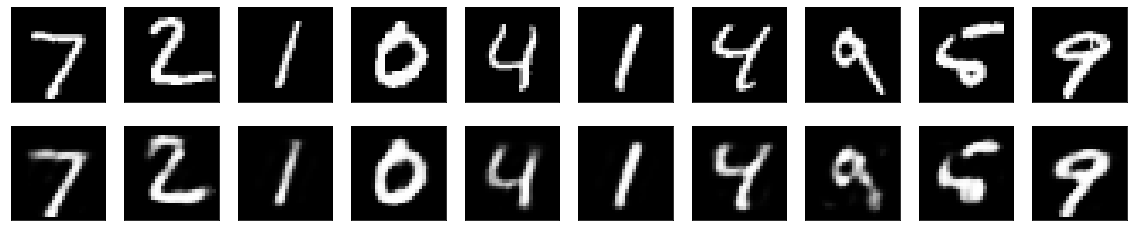

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
